In [35]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file

def patch_asscalar(a):
    return a.item()
setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.len()
setattr(np, "alen", patch_alen)

from mpol.__init__ import zenodo_record
from mpol import coordinates, gridding


import torch
from torch.utils import tensorboard

2024-02-21 16:17:36.106248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
from mpol import fourier, losses, precomposed, utils
from mpol.__init__ import zenodo_record

In [97]:
# load the mock dataset of the ALMA logo
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = np.real(data)
data_im = np.imag(data)

nchan = 1

nvis = uu.shape
print("Dataset has {:} channels".format(nchan))
print("Dataset has {:} visibilities".format(nvis))

Dataset has 1 channels
Dataset has (325080,) visibilities


Text(0, 0.5, '$v$ [k$\\lambda$]')

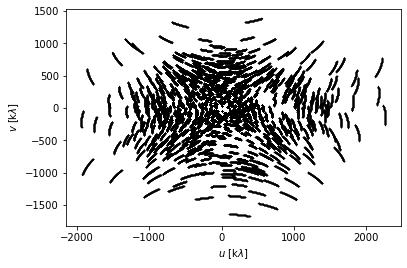

In [101]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")

In [102]:
coords = coordinates.GridCoords(cell_size=0.005*800/512, npix=512)
coords.img_ext

[1.99609375, -2.00390625, -2.00390625, 1.99609375]

In [103]:
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

In [104]:
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)

print(beam.shape)
print(img.shape)

(1, 512, 512)
(1, 512, 512)


In [112]:
img, beam = np.squeeze(img), np.squeeze(beam)

In [58]:
#img, beam = imager.get_dirty_image(
#    weighting="uniform", check_visibility_scatter=True, max_scatter=1.2
#)

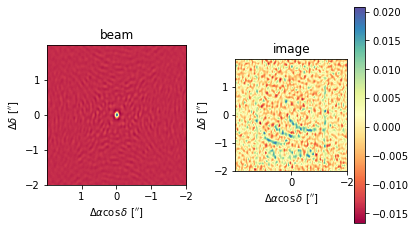

In [158]:
kw = {"origin": "lower", "interpolation": "none", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=2, figsize=(6.0, 4))
ax[0].imshow(beam, **kw)
ax[0].set_title("beam")
a = ax[1].imshow(img, **kw)
plt.colorbar(a)
ax[1].set_title("image")
for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
fig.subplots_adjust(left=0.14, right=0.90, wspace=0.35, bottom=0.15, top=0.9)

In [114]:
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)

dset = (
    averager.to_pytorch_dataset()
)

In [115]:
averager.nchan

1

In [118]:
coords

In [139]:
from mpol.precomposed import SimpleNet

model = SimpleNet(coords=coords, nchan=averager.nchan)

optimizer = torch.optim.SGD(model.parameters(), lr=3e4)

In [120]:
list(model.state_dict().items())[0][1].min(), list(model.state_dict().items())[0][1].max()

(tensor(0.0500, dtype=torch.float64), tensor(0.0500, dtype=torch.float64))

In [140]:
model.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       ...,
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
                       [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],
                     dtype=torch.float64)),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]], dtype=torch.float64)),
             ('conv_layer.m.bias', tensor([0.], dtype=torch.float64))])

<Figure size 432x288 with 0 Axes>

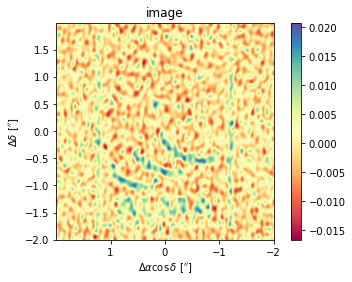

In [123]:
plt.set_cmap(
    "Spectral"
)  # using Matplotlib diverging colormap to accentuate negative values
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
snp = ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(snp)

In [145]:
model.zero_grad()

In [146]:
vis = model()
vis

tensor([[[ 1.1473e+01+0.0000e+00j,  1.1215e-02+6.8812e-05j,
          -1.1213e-02-1.3761e-04j,  ...,
           1.1211e-02-2.0640e-04j, -1.1213e-02+1.3761e-04j,
           1.1215e-02-6.8812e-05j],
         [ 1.1215e-02+6.8812e-05j,  1.0962e-05+1.3453e-07j,
          -1.0960e-05-2.0177e-07j,  ...,
           1.0960e-05-1.3451e-07j, -1.0962e-05+6.7260e-08j,
           1.0962e-05-1.3103e-21j],
         [-1.1213e-02-1.3761e-04j, -1.0960e-05-2.0177e-07j,
           1.0958e-05+2.6900e-07j,  ...,
          -1.0960e-05+6.7250e-08j,  1.0961e-05-1.9323e-21j,
          -1.0962e-05-6.7260e-08j],
         ...,
         [ 1.1211e-02-2.0640e-04j,  1.0960e-05-1.3451e-07j,
          -1.0960e-05+6.7250e-08j,  ...,
           1.0952e-05-4.0337e-07j, -1.0955e-05+3.3620e-07j,
           1.0957e-05-2.6899e-07j],
         [-1.1213e-02+1.3761e-04j, -1.0962e-05+6.7260e-08j,
           1.0961e-05+4.2352e-22j,  ...,
          -1.0955e-05+3.3620e-07j,  1.0958e-05-2.6900e-07j,
          -1.0960e-05+2.0177e-07j],
 

In [147]:
# calculate a loss
loss = losses.nll_gridded(vis, dset)
print(loss.item())

2.5860249635481276


In [148]:
loss

tensor(2.5860, dtype=torch.float64, grad_fn=<MulBackward0>)

In [149]:
loss.backward()

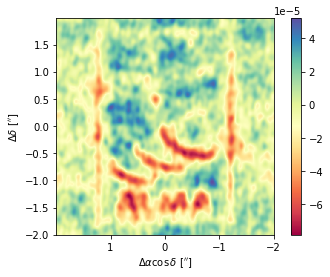

In [130]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(
        utils.packed_cube_to_sky_cube(model.bcube.base_cube.grad).detach().numpy()
    ),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)

In [133]:
model.bcube.base_cube.grad

tensor([[[-2.1835e-05, -2.3596e-05, -2.5073e-05,  ..., -1.5952e-05,
          -1.7925e-05, -1.9913e-05],
         [-1.8655e-05, -2.0414e-05, -2.1876e-05,  ..., -1.2759e-05,
          -1.4729e-05, -1.6725e-05],
         [-1.5517e-05, -1.7266e-05, -1.8709e-05,  ..., -9.6348e-06,
          -1.1594e-05, -1.3589e-05],
         ...,
         [-3.1177e-05, -3.2911e-05, -3.4421e-05,  ..., -2.5443e-05,
          -2.7394e-05, -2.9318e-05],
         [-2.8141e-05, -2.9888e-05, -3.1389e-05,  ..., -2.2346e-05,
          -2.4307e-05, -2.6257e-05],
         [-2.5013e-05, -2.6769e-05, -2.8259e-05,  ..., -1.9165e-05,
          -2.1135e-05, -2.3106e-05]]], dtype=torch.float64)

# Starting from dirty image

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.utils.data import download_file
from mpol import coordinates, gridding, losses, precomposed, utils
from mpol.__init__ import zenodo_record

In [161]:
# load the mock dataset of the ALMA logo
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... but for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = data.real
data_im = data.imag

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(
    cell_size=0.03, npix=180
)  # Smaller cell size and larger npix value can greatly increase run time
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset()

In [162]:
# Calculate the dirty image
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im)

img, beam = imager.get_dirty_image(weighting="briggs", robust=1.0, unit="Jy/arcsec^2")

<Figure size 432x288 with 0 Axes>

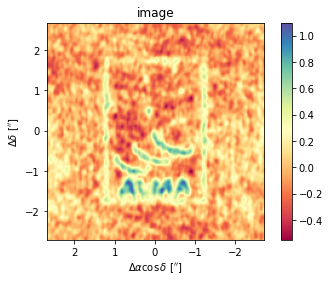

In [163]:
plt.set_cmap(
    "Spectral"
)  # using Matplotlib diverging colormap to accentuate negative values
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
snp = ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(snp)

In [164]:
dirty_image = torch.tensor(img.copy())  # turns it into a pytorch tensor
rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
optimizer = torch.optim.SGD(
    rml.parameters(), lr=1000.0
)  # multiple different possiple optimizers

In [165]:
loss_tracker = []
for iteration in range(50):

    optimizer.zero_grad()

    rml()

    sky_cube = rml.icube.sky_cube

    lossfunc = torch.nn.MSELoss(
        reduction="sum"
    )  # the MSELoss calculates mean squared error (squared L2 norm), so we take the sqrt of it
    loss = (lossfunc(sky_cube, dirty_image)) ** 0.5

    loss_tracker.append(loss.item())
    loss.backward()
    optimizer.step()
#
# We see that the optimization has completed successfully

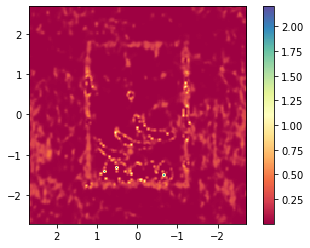

In [166]:
img = np.squeeze(rml.icube.sky_cube.detach().numpy())
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    img, origin="lower", interpolation="none", extent=rml.icube.coords.img_ext
)
plt.colorbar(im)

# Trying stellar model

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.utils.data import download_file
from mpol import coordinates, gridding, losses, precomposed, utils
from mpol.__init__ import zenodo_record

# CASA TOOLS AND VISREAD

In [1]:
import numpy as np

def patch_asscalar(a):
    return a.item()
setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.len()
setattr(np, "alen", patch_alen)

import matplotlib.pyplot as plt
from astropy.constants import c
from astropy.utils.data import download_file

import tempfile
import tarfile
import os

In [3]:
fname = 'twhya_smoothed.ms'

In [4]:
import casatools

msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()

In [71]:
tb.open(fname)
ant1 = tb.getcol("ANTENNA1")  # array of int with shape [nvis]
ant2 = tb.getcol("ANTENNA2")  # array of int with shape [nvis]
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
data = tb.getcol("DATA")  # array of complex128 with shape [npol, nchan, nvis]
tb.close()

True

In [82]:
uvw#.shape

array([[ 108.79658039,  -70.59373831,  -36.16480149, ...,  -45.54947703,
         -19.70774314,   25.84173389],
       [ -40.81840438,  -59.25369157, -105.20600999, ..., -109.66737059,
        -134.86581082,  -25.19844023],
       [ 122.68207671,  -81.69978203,  -43.45636909, ...,  -17.91771766,
           2.48818864,   20.4059063 ]])

In [83]:
data

array([[[ 5.42758942-4.73215532j, -0.80201972+1.75155163j,
         -0.89295292-1.73849142j, ..., -1.84271467-7.92216682j,
         -2.10453057+3.99418712j,  3.74449778+1.23224831j],
        [-3.68731451+5.53946304j, -0.64794362-0.21709859j,
         -1.32632172+3.27117586j, ...,  0.20002654-2.30977774j,
         -3.01517582-1.88039935j, -1.14218974+4.51142788j],
        [ 1.66965008+5.45137072j, -1.62627959+2.91809845j,
          3.09143853+5.17700243j, ..., -4.95733595+0.14714915j,
          3.26579618-4.17634296j,  3.74915886+1.16242218j],
        ...,
        [-0.87925547-0.35267961j,  0.75069618-4.63376284j,
          5.35098028-3.93577957j, ...,  0.9863776 -8.25191498j,
          2.04408407+1.76506913j,  0.32151338-4.27513647j],
        [-1.40231442+0.49625659j,  3.2954092 -7.58604336j,
          0.55003822-3.64753366j, ...,  4.12724638-3.4446454j ,
         -3.3718338 -5.08734465j,  0.37991035+5.98524475j],
        [ 2.12224722+0.67501843j,  1.15156889-1.20612347j,
          1.5

In [9]:
# get the channel information
tb.open(fname + "/SPECTRAL_WINDOW")
chan_freq = tb.getcol("CHAN_FREQ")
num_chan = tb.getcol("NUM_CHAN")
tb.close()
chan_freq = chan_freq.flatten()  # Hz
nchan = len(chan_freq)

In [10]:
if (nchan > 1) and (chan_freq[1] > chan_freq[0]):
    # reverse channels
    chan_freq = chan_freq[::-1]
    data = data[:, ::-1, :]
    flag = flag[:, ::-1, :]

In [11]:
xc = np.where(ant1 != ant2)[0]
data = data[:, :, xc]
flag = flag[:, :, xc]
uvw = uvw[:, xc]
weight = weight[:, xc]

In [12]:
# average the polarizations
data = np.sum(data * weight[:, np.newaxis, :], axis=0) / np.sum(weight, axis=0)
flag = np.any(flag, axis=0)
weight = np.sum(weight, axis=0)

In [13]:
# After this step, ``data`` should be shape ``(nchan, nvis)`` and weights should be shape ``(nvis,)``
print(data.shape)
print(flag.shape)
print(weight.shape)

(48, 44772)
(48, 44772)
(44772,)


In [14]:
# when indexed with mask, returns valid visibilities
mask = ~flag

In [15]:
# convert uu and vv to lambda
uu, vv, ww = uvw  # unpack into len nvis vectors
# broadcast to the same shape as the data
# stub to broadcast uu,vv, and weights to all channels
broadcast = np.ones((nchan, 1))
uu = uu * broadcast
vv = vv * broadcast
weight = weight * broadcast

In [16]:
# calculate wavelengths in meters
wavelengths = c.value / chan_freq[:, np.newaxis]  # m

In [17]:
# calculate baselines in lambda
uu = uu / wavelengths  # [lambda]
vv = vv / wavelengths  # [lambda]

In [18]:
frequencies = chan_freq * 1e-9  # [GHz]

In [19]:
# save data to numpy file for later use
np.savez(
    "visibilities.npz",
    frequencies=frequencies,  # [GHz]
    uu=uu,  # [lambda]
    vv=vv,  # [lambda]
    weight=weight,  # [1/Jy^2]
    data=data,  # [Jy]
    mask=mask,  # [Bool]
)

In [20]:
vis_file_name = "visibilities.npz"

In [63]:
# load extracted visibilities from npz file
d = np.load(vis_file_name)

chan = 24

uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]

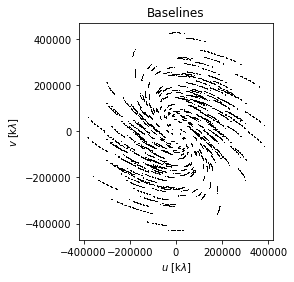

In [64]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(-uu, -vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_aspect("equal")
ax.set_title("Baselines")

plt.show()

In [69]:
cell_size = 0.002  # [arcsec]

In [70]:
from mpol import gridding

imager = gridding.DirtyImager.from_image_properties(
    cell_size=cell_size,
    npix=512,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,  # separating the real and imaginary values of our data
    data_im=data.imag,
)

CellSizeError: Dataset contains uu spatial frequency measurements larger than those in the proposed model image. Decrease cell_size below 0.0004820019342737633 arcsec.

In [67]:
def image_and_plot(weighting, robust=None):

    img, beam = imager.get_dirty_image(
        weighting=weighting, robust=robust, unit="Jy/arcsec^2"
    )

    kw = {"origin": "lower", "extent": imager.coords.img_ext}
    fig, ax = plt.subplots(ncols=1)
    im = ax.imshow(np.squeeze(img), **kw)
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\mathrm{Jy}/\mathrm{arcsec}^2$")

    title = weighting
    if robust is not None:
        title += " r={:.1f}".format(robust)
    ax.set_title(title)
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    #r = 0.7
    #plt.xlim(left=r, right=-r)
    #plt.ylim(bottom=-r, top=r)

    return np.squeeze(img)

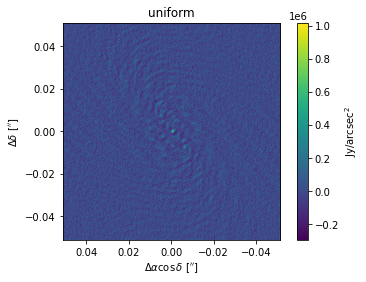

In [68]:
_ = image_and_plot(weighting="uniform")

In [84]:
import numpy

filename = "test1.ms"

# Define data dimensions.
num_pols = 4
num_channels = 2
num_stations = 3
num_times = 4
num_baselines = num_stations * (num_stations - 1) // 2
ref_freq_hz = 100e6
freq_inc_hz = 100e3
exposure_sec = 1.0
interval_sec = 1.0

# Data to write are stored as numpy arrays.
uu = numpy.zeros([num_baselines])
vv = numpy.zeros_like(uu)
ww = numpy.zeros_like(uu)
vis = numpy.zeros([num_times, num_channels,
                   num_baselines, num_pols], dtype='c8')

# Create the empty Measurement Set.
ms = oskar.MeasurementSet.create(filename, num_stations,
                                 num_channels, num_pols,
                                 ref_freq_hz, freq_inc_hz)

# Set phase centre.
ra_rad = numpy.pi / 4
dec_rad = -numpy.pi / 4
ms.set_phase_centre(ra_rad, dec_rad)

# Write data one block at a time.
for t in range(num_times):
    # Dummy data to write.
    time_stamp = 51544.5 * 86400.0 + t
    uu[:] = 1e0 * t + 1
    vv[:] = 1e1 * t + 2
    ww[:] = 1e2 * t + 3
    for c in range(num_channels):
        for b in range(num_baselines):
            vis[t, c, b, :] = (t * 10 + b) + 1j * (c + 1)

    # Write coordinates and visibilities.
    start_row = t * num_baselines
    ms.write_coords(start_row, num_baselines, uu, vv, ww,
                    exposure_sec, interval_sec, time_stamp)
    ms.write_vis(start_row, 0, num_channels, num_baselines, vis[t, ...])

NameError: name 'oskar' is not defined